# Προσομοιωμένη Ανόπτηση

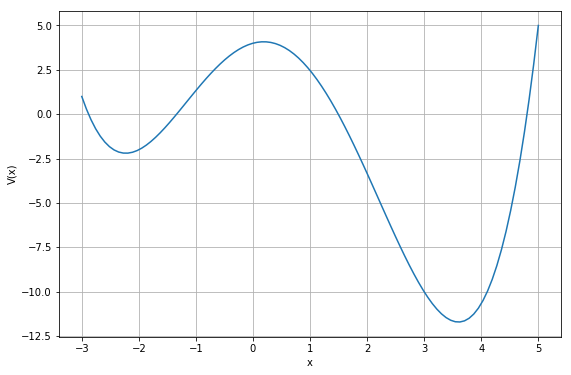

In [86]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2017)  # for reproducibility

%matplotlib inline

def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4.0), x)

x = np.linspace(-3, 5, 100)

plt.figure(figsize = (9, 6))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

In [104]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

est = []

for i in range(200):
    path = sim_anneal(V, -4, 4, delta = 1.,
                      T = T_start, T_min = T_end,
                      cool_factor = cool_factor, 
                      cool_sch = cool_sch,
                      trace = True) # keep the default for the rest
    est.append(path[-1]) # last position

#path[-1]  # last position

In [122]:
est

[3.6006660411981914,
 3.597565168353555,
 3.6030303365023064,
 3.605483803161627,
 3.6064902641814887,
 3.603313229411684,
 3.6015966391462975,
 3.602131124583762,
 3.5958054191910063,
 3.602113390024525,
 3.603993719962325,
 3.5959369562473715,
 3.598126290904131,
 3.6057743238589843,
 3.599759167721095,
 3.6003222048477883,
 3.5986591443920046,
 3.609175445895225,
 3.59590213106129,
 3.6019244916005695,
 3.591678555269535,
 3.6012494821436736,
 3.603451587811873,
 3.5902476263188436,
 3.600008444490412,
 3.6043597220013353,
 3.602251478758004,
 3.6025557151745846,
 3.6006878886979607,
 3.610546774540023,
 3.5964447641917303,
 3.596236462010883,
 3.597196792356166,
 3.6008009039633424,
 3.6071747538647556,
 3.5949518876376643,
 3.6034772098104115,
 3.5990875376225224,
 3.6028391967551823,
 3.6034458057688923,
 3.6031051419375135,
 3.606106024758313,
 3.6044258380814176,
 3.599013469740078,
 3.607213525245362,
 3.5941734255651743,
 3.6000770431166433,
 3.6010793165433257,
 3.6012043073

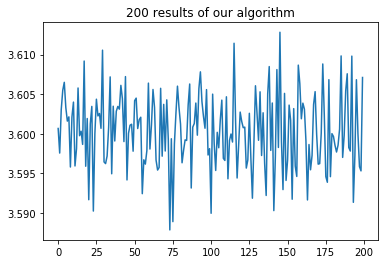

In [107]:
plt.plot(est)
plt.title('200 results of our algorithm')

Όπως βλέπουμε, ο αλγόριθμος εντόπισε και στις 200 περιπτώσεις το ολικό ελάχιστο που βρίσκεται στην θέση 3.6. 

In [114]:
T_start, T_end = 2.0, 2**(-12)
cool_sch = 100

count = [0, 0, 0, 0, 0, 0, 0, 0]
prob = [0, 0, 0, 0, 0, 0, 0, 0]
cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

for k in range(8):
    for i in range(200):
        path = sim_anneal(V, -4, 4, delta = 1.,
                          T = T_start, T_min = T_end,
                          cool_factor = cool_factor[k], 
                          cool_sch = cool_sch,
                          trace = True) # keep the default for the rest
        if (abs(path[-1] - 3.6) < 0.05): count[k] += 1 
    prob[k] = count[k]/200


#from scipy.signal import argrelextrema

#argrelextrema(V(x), np.less)

In [128]:
prob

[0.56, 0.605, 0.61, 0.59, 0.665, 0.745, 0.83, 0.995]

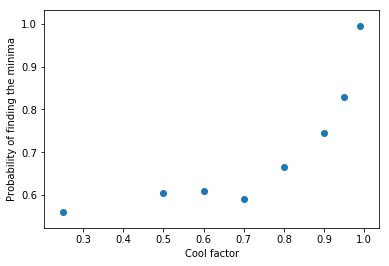

In [130]:
plt.scatter(cool_factor, prob)
plt.xlabel('Cool factor')
plt.ylabel('Probability of finding the minima')

Καθώς αυξάνεται ο cool factor, αυξάνεται και η πιθανότητα επιτυχίας του αλγορίθμου μας.

# Salesman problem

In [141]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
#city_coord["Athens"]

In [142]:
def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

In [143]:
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

In [144]:
for i, city in enumerate(city_coord): print(i, city)

0 Brussels
1 Tirana
2 Andorra la Vella
3 Vienna
4 Minsk
5 Sarajevo
6 Sofia
7 Zagreb
8 Nicosia
9 Prague
10 Copenhagen
11 London
12 Tallinn
13 Helsinki
14 Paris
15 Marseille
16 Tbilisi
17 Berlin
18 Athens
19 Budapest
20 Reykjavik
21 Dublin
22 Rome
23 Pristina
24 Riga
25 Vaduz
26 Vilnius
27 Luxembourg
28 Skopje
29 Valletta
30 Chisinau
31 Monaco
32 Podgorica
33 Amsterdam
34 Belfast
35 Oslo
36 Warsaw
37 Lisbon
38 Bucharest
39 Moscow
40 San Marino
41 Edinburgh
42 Belgrade
43 Bratislava
44 Ljubljana
45 Madrid
46 Stockholm
47 Bern
48 Kiev
49 Cardiff


In [135]:
def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

In [136]:
def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

In [156]:
# Annealing Parameters
Temp = 10 ** 8
Temp_end = 0.005
cool_factor = 0.99
cool_schedule = 80

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      71%
Initial distance:	100118 km
Optimal distance:	29223 km


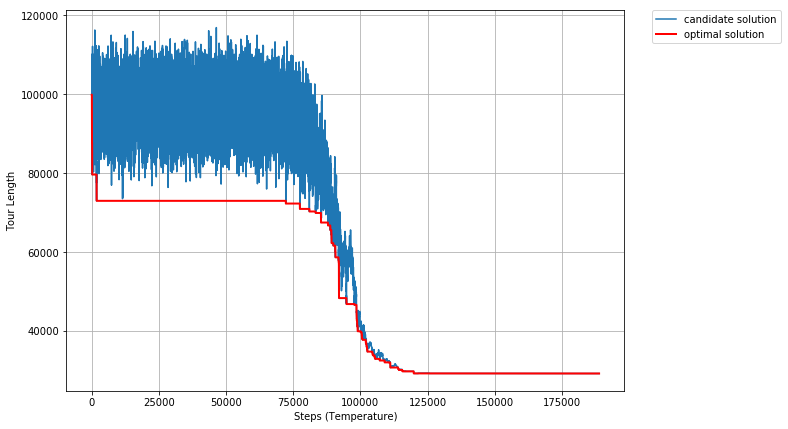

In [157]:
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

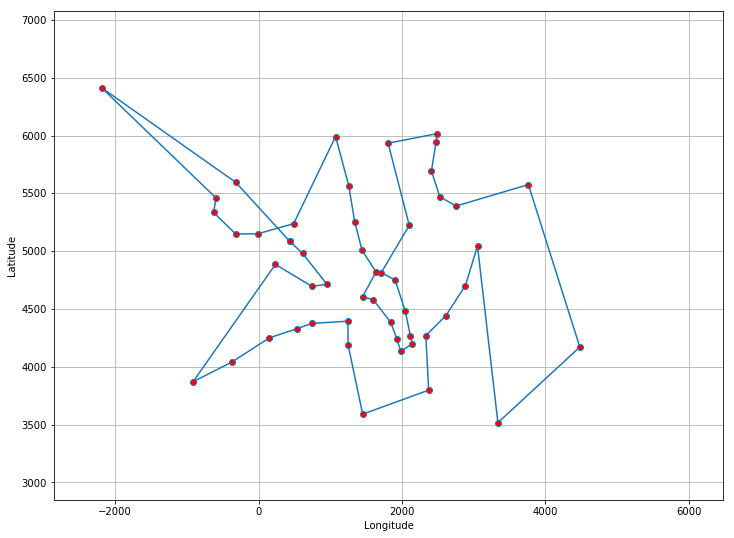

In [158]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
plt.show()

1. Αλλάξαμε λίγο τις παραμέτρους (cooling factor -> $0.99$, final temperature -> $0.005$) και φαίνεται να πετύχαμε μια κάποια βελτίωση στο αποτέλεσμα για input 50 πόλεις (improvement: 68% -> 71% ).
2. * Υπάρχουν $49!/2$ τέτοια μονοπάτια για 50 πόλεις, αφού, ξεκινώντας από μία πόλη, διαλέγουμε αρχικά μία απ' τις 49 υπόλοιπες, μετά μία απ' τις 48 κοκ. Διαιρούμε με το 2, γιατί οι διαδρομές είναι κυκλικές.
   * $49!/2 = 304140932017133780436126081660647688443776415689605120000000000$, δηλαδή θα χρειαζόμασταν 304 novemdecillion 140 octodecillion 932 septendecillion 17 sexdecillion 133 quindecillion 780 quattuordecillion 436 tredecillion 126 duodecillion 81 undecillion 660 decillion 647 nonillion 688 octillion 443 septillion 776 sextillion 415 quintillion 689 quadrillion 605 trillion 120 billion msecs για να βρούμε το βέλτιστο μονοπάτι. Μάλλον δεν είναι πολύ καλός τρόπος να λύσουμε το πρόβλημα, ειδικά αν έχουμε κανονίσει κάτι για το βράδυ.